# House Prices Dataset Analysis - *Given information about a house, predict its price*

### Best score achieved: RMSE = 0.13882 - top 46% of submissions on Kaggle.

Last updated: November 2020

## How is this useful?

Being able to accuractely predict the price of houses is obviously a very powerful tool. For example, one can use a model to predict the price of a house based on information that they have, which can then be compared with what it has been valued at by an agent. If you find that the house has been listed for lower than what the model thinks it's worth, you could purchase the house and relist it for the higher price that the model predicted in order to make profit. Also, if your model was really good, you could sell it to some real estate agency to cut out the need for valuing houses.

## About the Dataset

This dataset contains information about various houses in the US. The dataset is of shape (1460,81), meaning we have 1460 observations of 81 features. The features are things like:

* Overall quality
* Basement surface area
* Condition of internal/external materials
* Garage size
* Garage condition etc.

The data is open source and can be viewed/downloaded from https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## About this Notebook

This notebook is split into 3 parts:

### Part 1: Dataset Exploration & Preprocessing
    1. Viewing the Data
    2. Feature Engineering
    3. Addressing Missing Values
    4. Independent/Dependent Variable Split + Feature Scaling
### Part 2: Model Training & Prediction
    1. Fitting XGBoost
    2. Predicting the Test Set Prices
    3. Regression Model Comparison
### Part 3: Summary and Conclusions
    1. Key Takeaways
    2. Limitations
    3. Future Work

## Part 1: Dataset Exploration and Feature Engineering

### 1) Viewing the Data

First we print the shape of the training set and find that it is 1460x81. During the data exploration it will be useful to identify the best predictors of house price.

Another to notice is that the test set contains 1 fewer feature compared to the training set. This feature is the dependent variable that we are trying to predict (sale price). The feature is omitted because Kaggle calculates the quality of the predictions. Therefore, we do not need to establish an evaluation pipeline.

In [50]:
# library imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import math

In [51]:
# read in the dataset, print shape and column titles
train_set = pd.read_csv('train.csv')
print("Training set shape: ", train_set.shape)

test_set = pd.read_csv('test.csv')
print("Test set shape: ", test_set.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)


We first investigate the dependent variable (sale price). We can immediately see that this distribution is non Gaussian. One of the main assumptions of multivariate analysis is that variables are normally distributed. We can convert this distribution to a Gaussian by a log transform.

We can also print several summary statistics to get a better feal for this variable. we can see that there is no missing data and there are no houses with a sale price of 0, which means that all is in order.

Sale price summary statistics
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


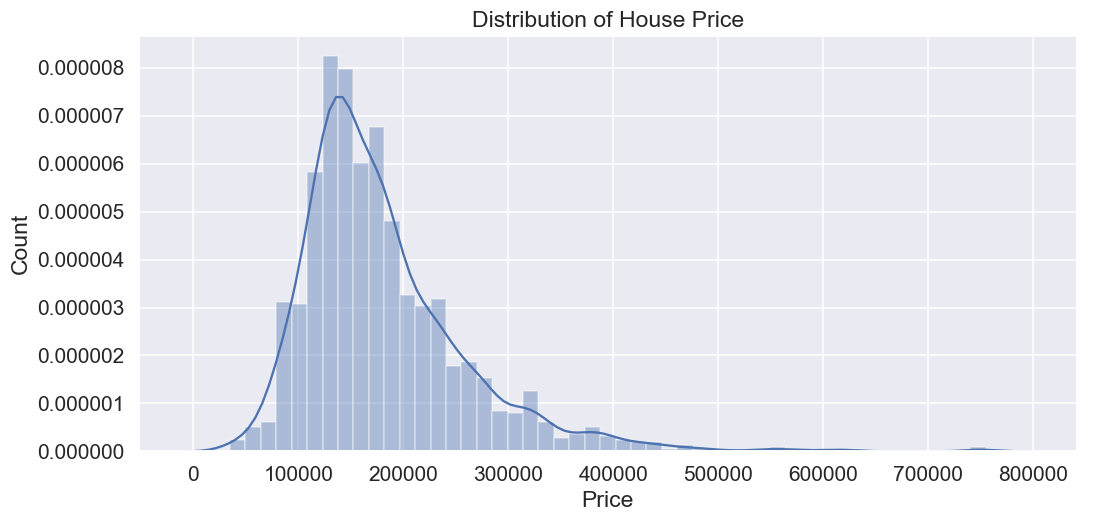

Skew of sale price:  1.8828757597682129


In [52]:
print("Sale price summary statistics")
print(train_set['SalePrice'].describe())

saleprice = train_set.iloc[:,-1].values

plt.figure(dpi=110,figsize=(11,5))
sns.distplot(saleprice)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of House Price')
plt.show()

print("Skew of sale price: ", train_set['SalePrice'].skew())

To get a better idea of how the features in our dataset correlate with the sale price, we can display a correlation matrix, which shows the PMCC for each feature pair.

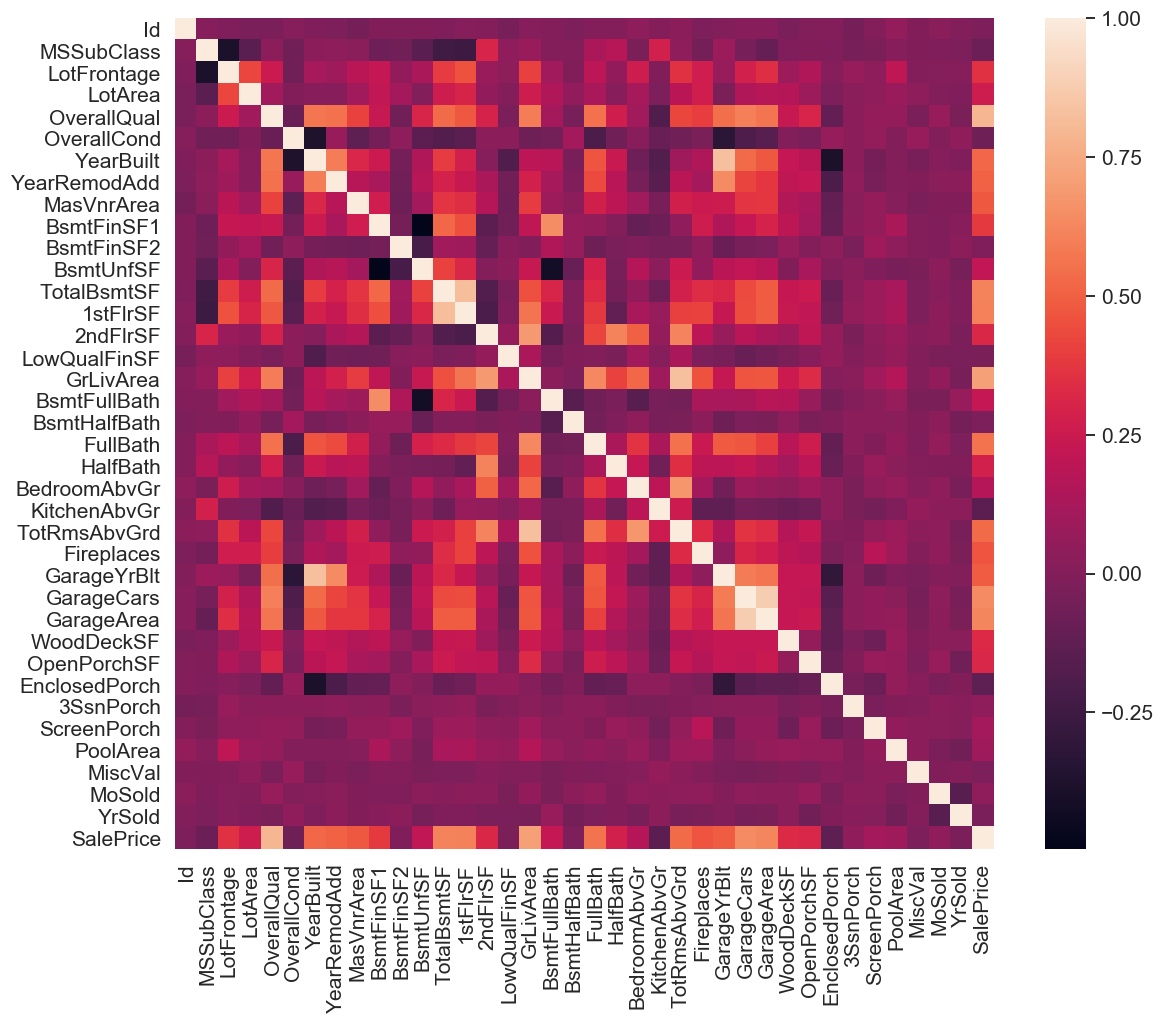

In [53]:
correlation_matrix = train_set.corr()

plt.figure(dpi=110,figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False)
plt.show()

We can use this correlation matrix to identify the best predictors of the sale price dependent variable. We find that these are: Overall quality, general living area, number of garage cars, garage area, basement surface area, 1st floor surface area, number of full bathrooms, total rooms above ground and the year built.

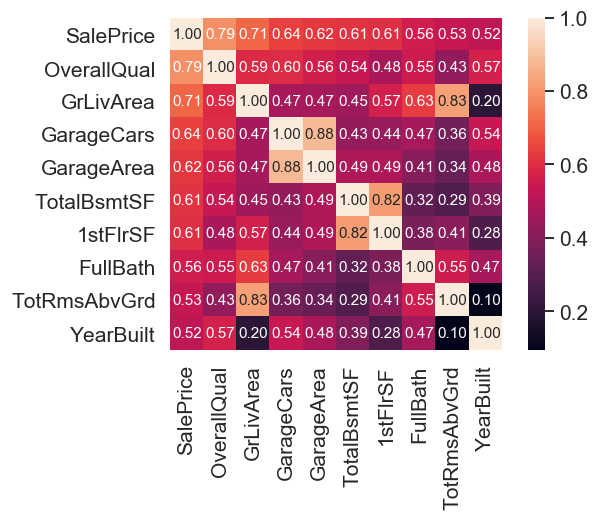

In [54]:
k = 10
cols = correlation_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_set[cols].values.T)

plt.figure(dpi=110)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Finally, we can create a pairwise scatter plot of each of these features to see in one figure the relationship between the features.

<Figure size 660x440 with 0 Axes>

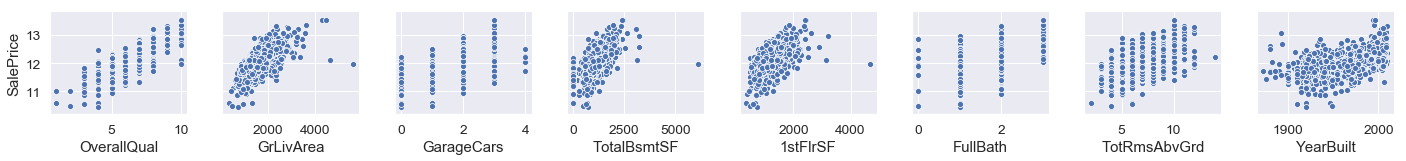

In [67]:
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

plt.figure(dpi=110)
sns.pairplot(data=train_set,y_vars=['SalePrice'],x_vars=features)
plt.show()

### 2) Feature Engineering

We can now address the fact that sale price is non Gaussian by applying a log transformation. This will improve the predictive power of our model.

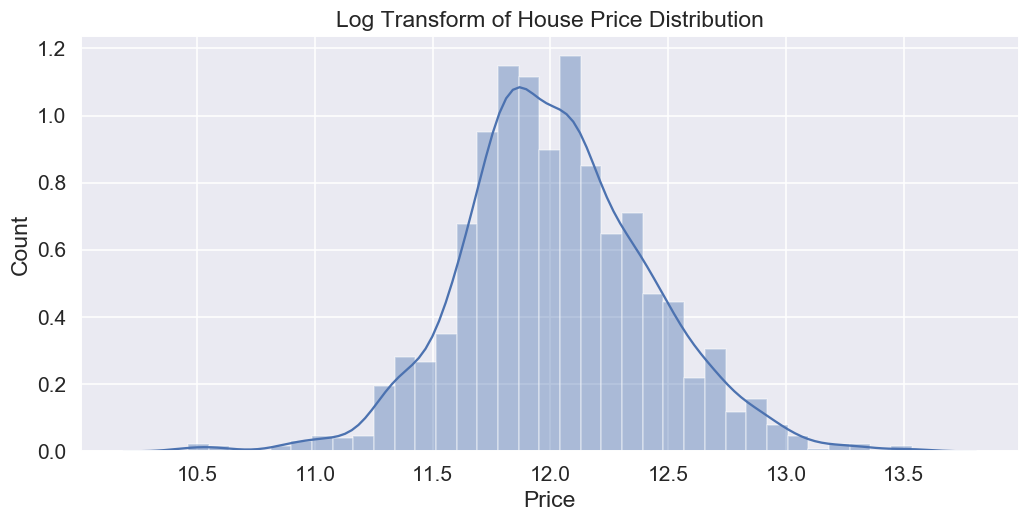

In [56]:
train_set['SalePrice'] = np.log(train_set['SalePrice'])

plt.figure(dpi=110,figsize=(11,5))
sns.distplot(train_set['SalePrice'])
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Log Transform of House Price Distribution')
plt.show()

Going forward, we will be dealing with independent variables, so it makes sense to concatenate the training and test sets into one dataframe in order to manipulate them both at the same time.

In [57]:
intermediate = train_set.drop(columns=['SalePrice'])
dataset = pd.concat([intermediate, test_set])
dataset = dataset.drop(columns=['Id'])
print(dataset.shape)

(2919, 79)


From looking at the meta data, there are many categorical columns (>50), but a lot of the categorical columns are just numerical scales that are represented with words instead. For example, ExterQual is a feature describing the quality of the materials used for the exterior of the property and takes values from 'Ex' meaning Excellent to 'Po' meaning Poor. In reality this is just code for an ordinal scale with 5 levels. Since many columns in the dataset are like this (but with different codes), we can define a custom mapping between the column values and numerical labels and use OrdinalEncoder to transform each column.

In [58]:
ordinal_cols_mapping = [{
    "col": "ExterQual",
    "mapping": {
        'Po': 0, 
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "ExterCond",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "BsmtQual",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, { 
    "col": "BsmtCond",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "BsmtExposure",
    "mapping": {
        "NA": None,
        "No": 1,
        "Mn": 2,
        "Av": 3,
        "Gd": 4
    }}, {
    "col": "BsmtFinType1",
    "mapping": {
        "NA": None,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GlQ": 6
    }}, {
    "col": "BsmtFinType2",
    "mapping": {
        "NA": None,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GlQ": 6
    }}, {
    "col": "HeatingQC",
    "mapping": {
        "Po": 0,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 4
    }}, {
    "col": "CentralAir",
    "mapping": {
        "N": None,
        "Y": 1
    }}, {
    "col": "KitchenQual",
    "mapping": {
        "Po": 0,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 4
    }}, {
    "col": "Functional",
    "mapping": {
        "Sal": 0,
        "Sev": 1,
        "Maj2": 2,
        "Maj1": 3,
        "Mod": 4,
        "Min2": 5,
        "Min1": 6,
        "Typ": 7
    }}, {
    "col": "FireplaceQu",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "GarageType",
    "mapping": {
        "NA": None,
        "Detchd": 1,
        "CarPort": 2,
        "BuiltIn": 3,
        "Basment": 4,
        "Attchd": 5,
        "2Types": 6
    }}, {
    "col": "GarageFinish",
    "mapping": {
        "NA": None,
        "Unf": 1,
        "RFn": 2,
        "Fin": 3
    }}, {
    "col": "GarageQual",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "GarageCond",
    "mapping": {
        "NA": None,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
    }}, {
    "col": "PoolQC",
    "mapping": {
        "NA": None,
        "Fa": 1,
        "TA": 2,
        "Gd": 3,
        "Ex": 4
    }}, {
    "col": "Fence",
    "mapping": {
        "NA": None,
        "MnWw": 1,
        "GdWo": 2,
        "MnPrv": 3,
        "GdPrv": 4
    }}
]

encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, 
                             return_df = True)

dataset = encoder.fit_transform(dataset)

We can now remove all of the truly categorical features and we are left with only the numerical columns, which will work with our regression model.

After doing this the training set has 56 features.

### 3) Addressing Missing Values

We must now deal with missing values in our dataset. We can do this by plotting a chart of the percentage of `NaN` values in each column.

We observe that 3 features contain `NaN` values, the largest of which has around 17.5% of the column as `NaN`. From experimenting, for this particular dataset, it is actually better to just remove these features instead of imputing, so we drop the columns.

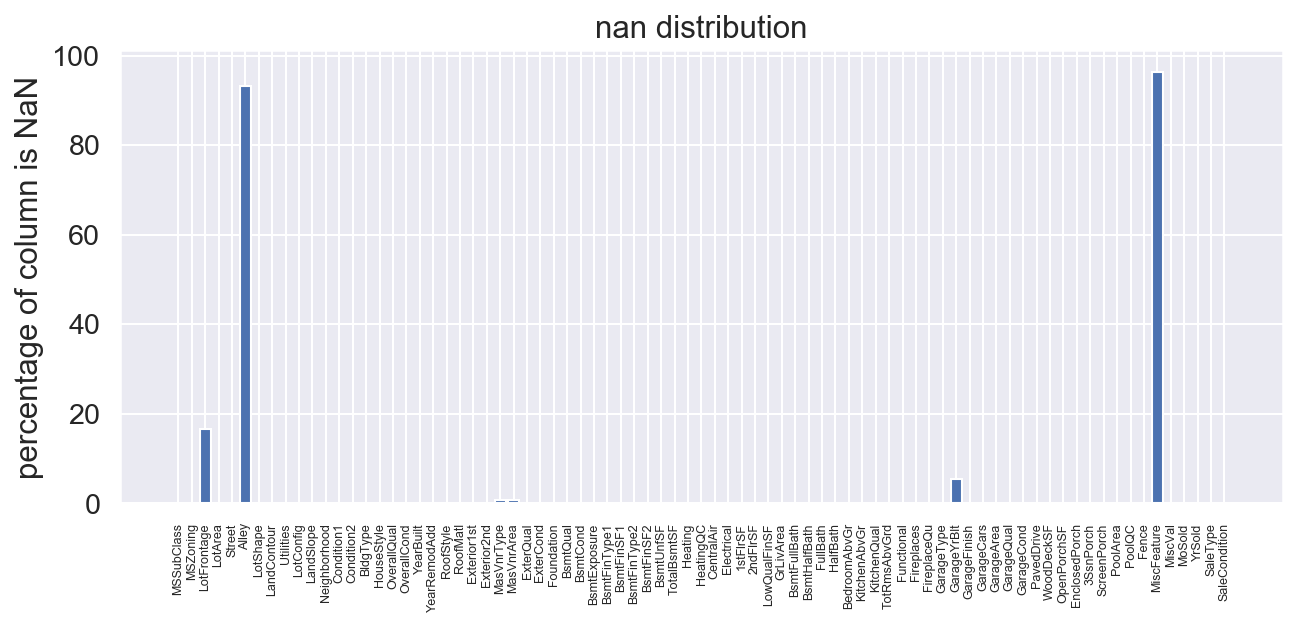

(2919, 59)


In [59]:
# count number of NaN values in the columns
nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append((all_nans[i]/len(dataset))*100)

# plot the number of NaN values per column
plt.figure(dpi=150,figsize=(10,4))
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical', fontsize=6)
plt.title('nan distribution')
plt.ylabel('percentage of column is NaN')
plt.show()

# deal with missing data
dataset = dataset.dropna(axis = 1, how='any')
print(dataset.shape)

Much like the sale price variable, the general living area feature is also highly skewed. We can address this by applying another log transform, normalising the feature.

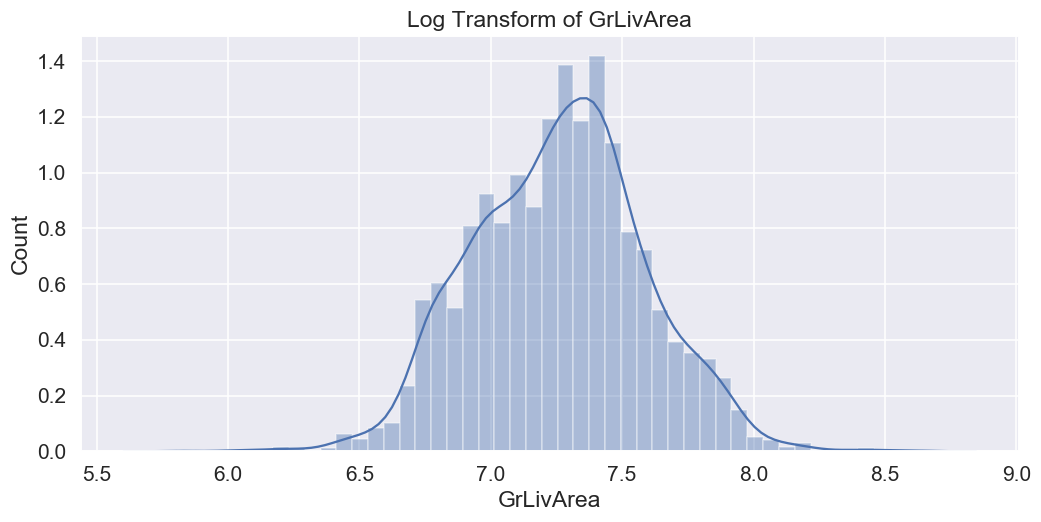

In [61]:
dataset['GrLivArea'] = np.log(dataset['GrLivArea'])

plt.figure(dpi=110,figsize=(11,5))
sns.distplot(dataset['GrLivArea'])
plt.xlabel('GrLivArea')
plt.ylabel('Count')
plt.title('Log Transform of GrLivArea')
plt.show()

Lastly, we can encode the remaining categorical variables using get_dummies(), for a final dataset with 151 features.

In [62]:
dataset = pd.get_dummies(dataset)
print(dataset.shape)

(2919, 151)


### 4) Independent/Dependent Variable Split + Feature Scaling

Since all the exploration is done, we can now split the dataset into the independent and dependent variables. We also need to apply feature scaling to both the independent and dependent variables.

In [63]:
X_train = dataset.iloc[0:1460,:].values
X_test = dataset.iloc[1460:,:].values

print(X_train.shape)
print(X_test.shape)

y_train = train_set['SalePrice'].values

# Feature Scaling
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_train)
y = sc_y.fit_transform(y_train.reshape(-1,1))

(1460, 151)
(1459, 151)


## Part 2: Model Training & Prediction

### 1) Fitting XGBoost

We now fit our regression model, which will be the XGBoost regressor. The XGBoost regressor often has the best 
performance when compared to other regression models like SVR and Random Forest.

In [64]:
# fitting XGboost to the training set
regressor = XGBRegressor()
regressor.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

### 2) Predicting the Test Set Prices

We create a list of the predicted values for the house prices of the test set. We can visualise the predicitons and compare the distribution of the predicted values to the training set values in order to see if we are on the right track.

We can see that the two distributions are very similar in general shape, our predicted prices are also left skewed, with a mode of around $150000. This is a very good sign that our predictions are accurate. However, the predicted distribution is slightly less sharply peaked compared with the training set distribution.

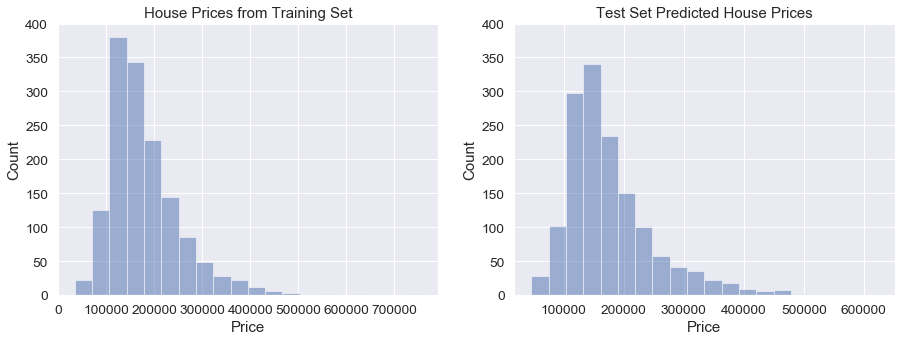

In [65]:
y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.hist(np.exp(y_train), 20, alpha=0.5)
ax1.set_title('House Prices from Training Set')
ax1.set_xlabel('Price')
ax1.set_ylim([0,400])
ax1.set_ylabel('Count')

ax2.hist(np.exp(y_pred), 20, alpha=0.5)
ax2.set_title('Test Set Predicted House Prices')
ax2.set_xlabel('Price')
ax2.set_ylim([0,400])
ax2.set_ylabel('Count')
plt.show()

Finally, we save our predictions as a csv file so that Kaggle can calculate the RMSE.

In [66]:
ids = list(test_set.iloc[:,0].values)

predictions = pd.DataFrame(np.exp(y_pred),index=ids)
predictions.rename(columns={ predictions.columns[0]: "SalePrice" }, inplace = True)
predictions = predictions.rename_axis("Id")

predictions.to_csv('predictons.csv')

### 3) Regression Model Comparison

We can compare the score achieved by the XGBoost Regressor vs other regression models by plotting the RMSE. Since Kaggle calculates the RMSE for us, we have not trained these models here. We can see that the XGBoost model produces the lowest RMSE of all the models.

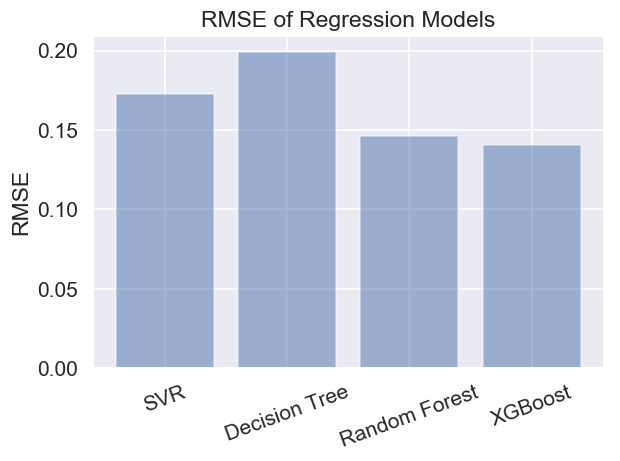

In [210]:
models = ['SVR', 'Decision Tree', 'Random Forest', 'XGBoost']
rsme = [0.17260, 0.19934, 0.14609, 0.14045]

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(models, rsme, alpha = 0.5)
plt.xticks([i for i in range(len(models))], models, rotation=20)
plt.title('RMSE of Regression Models')
plt.ylabel('RMSE')
plt.show()

## Part 3: Conclusion

### 1) Key Takeaways

### 2) Limitations & Future Work